PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4070 Ti SUPER
Current CUDA device: 0

Starting retinal segmentation training script

Creating dataset...
Found 3662 images in train_images
Dataset created with 3662 samples
Verifying dataset by loading first sample...
Sample image shape: torch.Size([3, 256, 256])
Sample mask shape: torch.Size([256, 256])
Creating data loader...
Initializing segmentation model...
Successfully initialized CUDA device
Model initialized and moved to cuda
Starting training...
Training on cuda
Training with 916 batches per epoch
Starting epoch 1/20
  Processing batch 1/916
Input shape: torch.Size([4, 3, 256, 256])
Output shape: torch.Size([4, 4, 256, 256])
Target shape: torch.Size([4, 256, 256])
  Processing batch 6/916
  Processing batch 11/916
  Processing batch 16/916
  Processing batch 21/916
  Processing batch 26/916
  Processing batch 31/916
  Processing batch 36/916
  Processing batch 41/916
  P

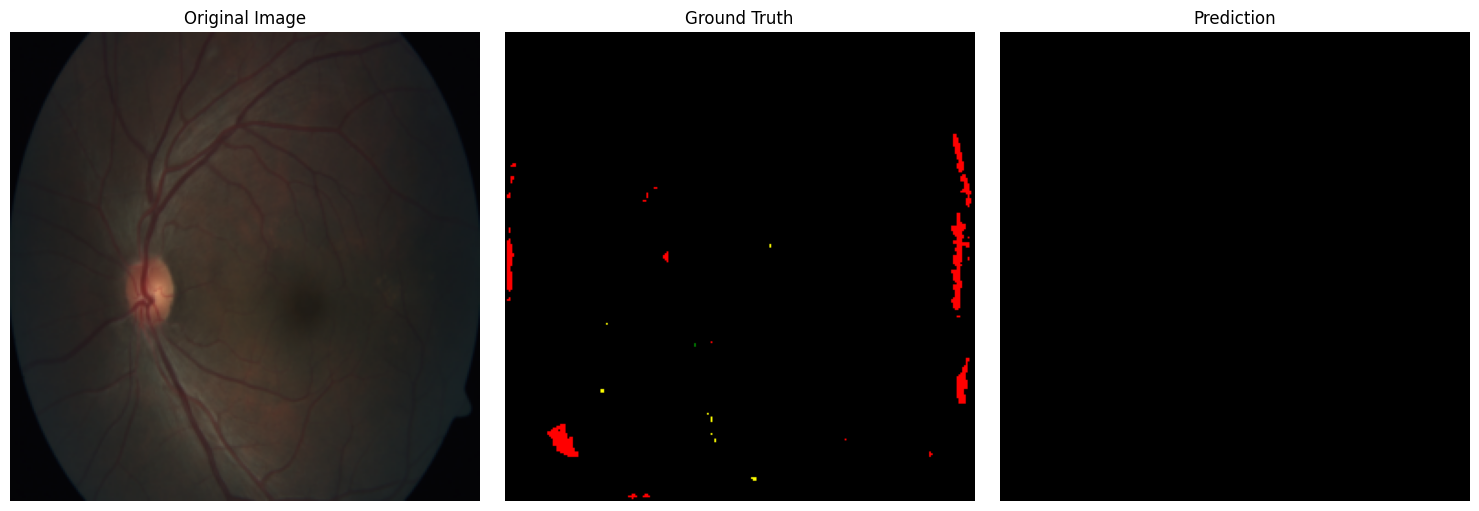

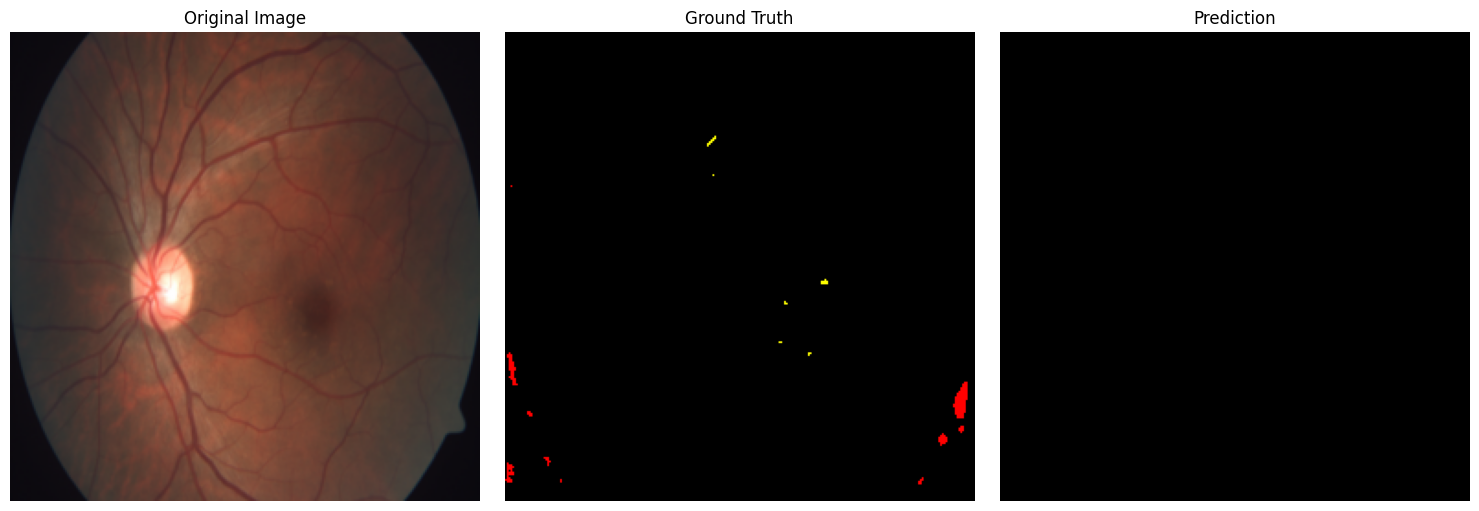

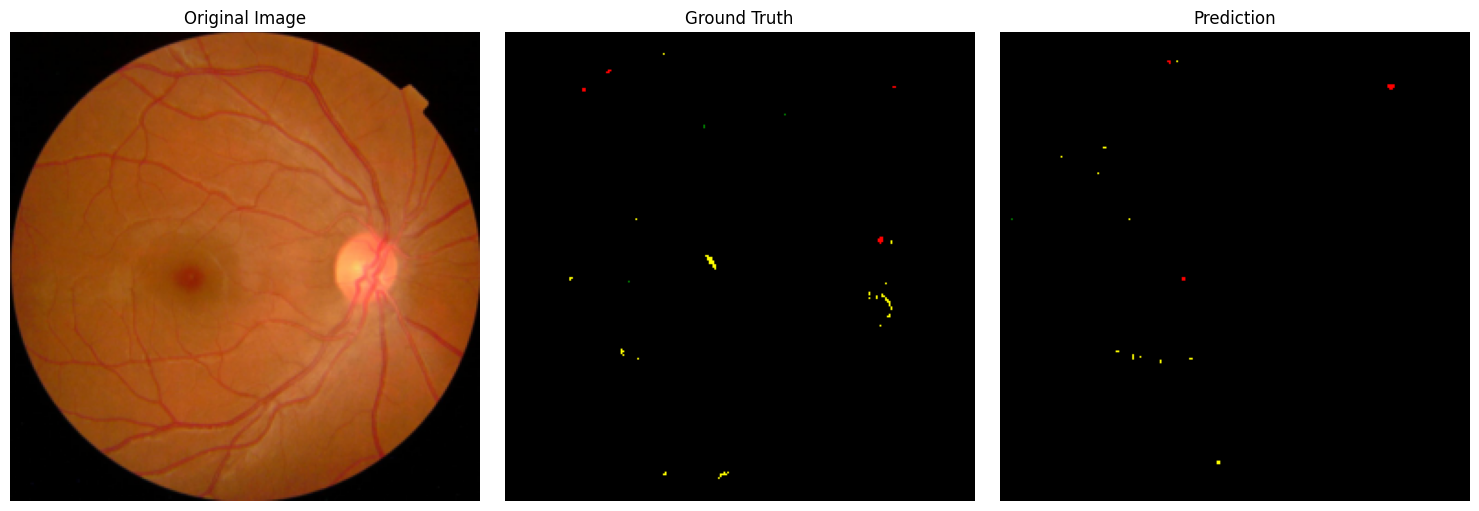

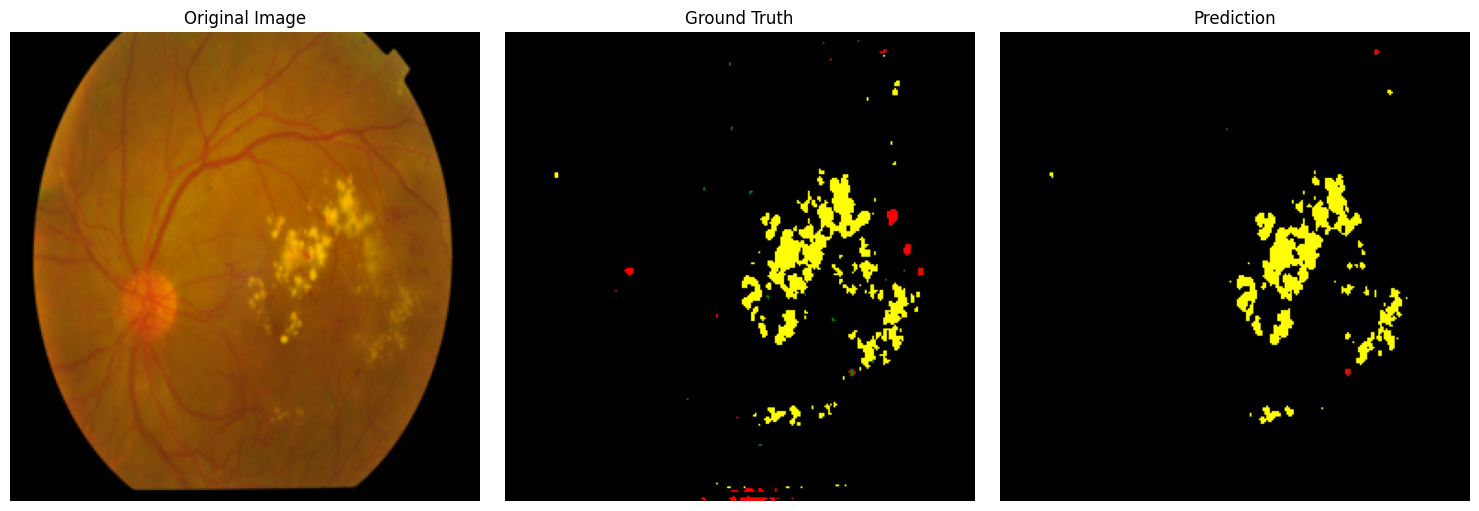

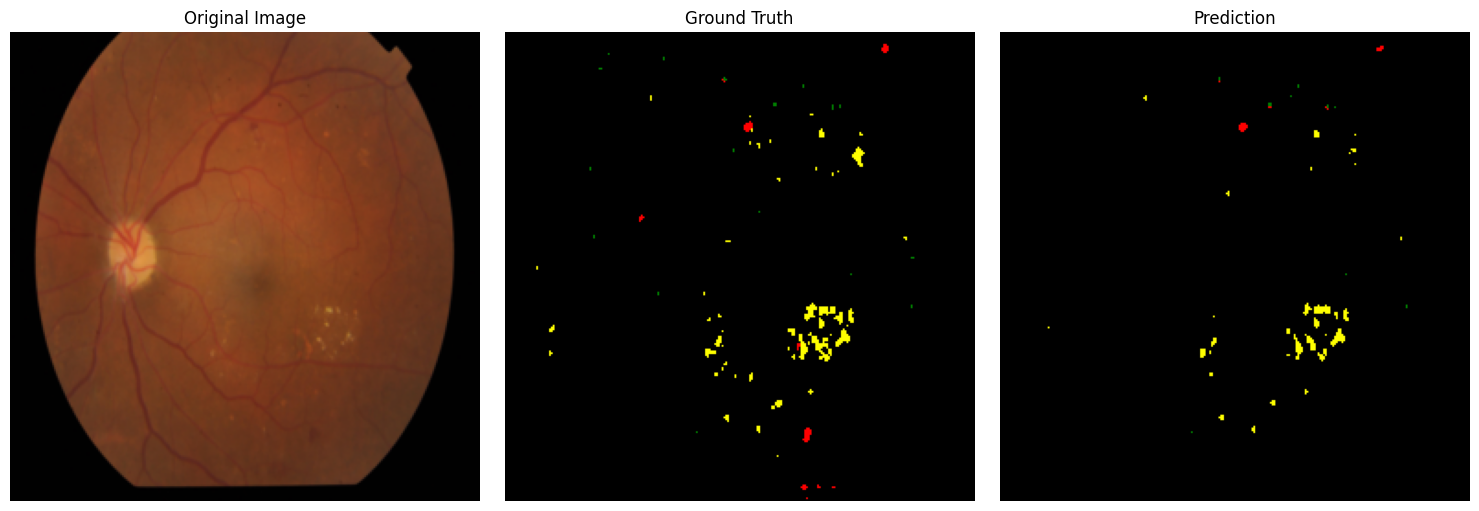

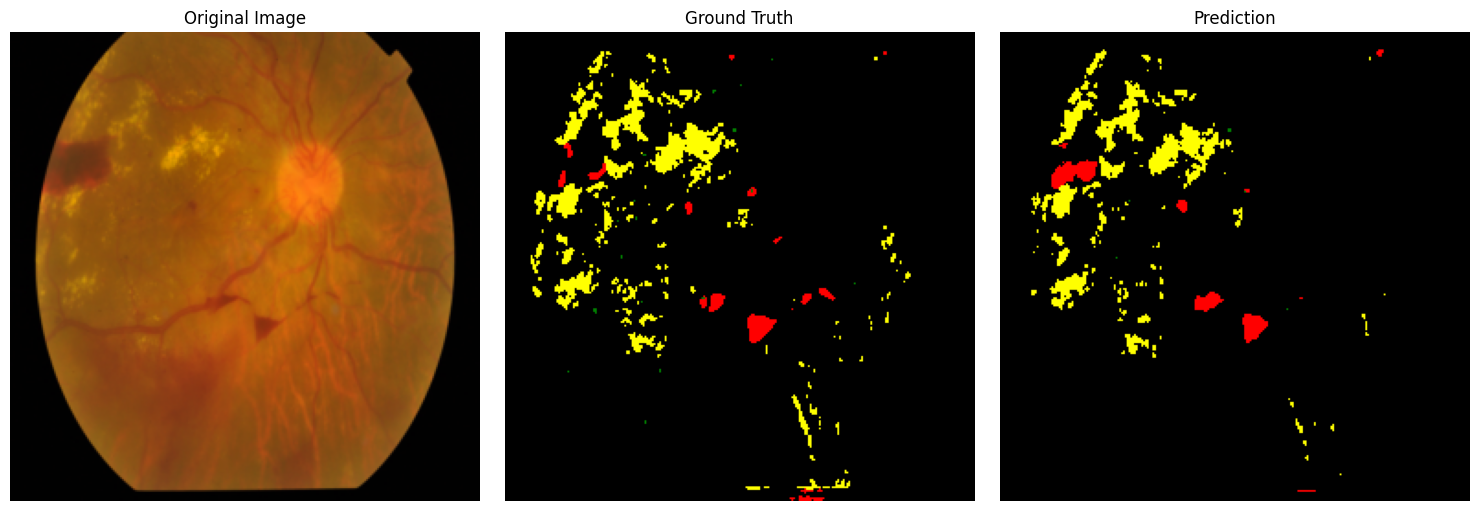

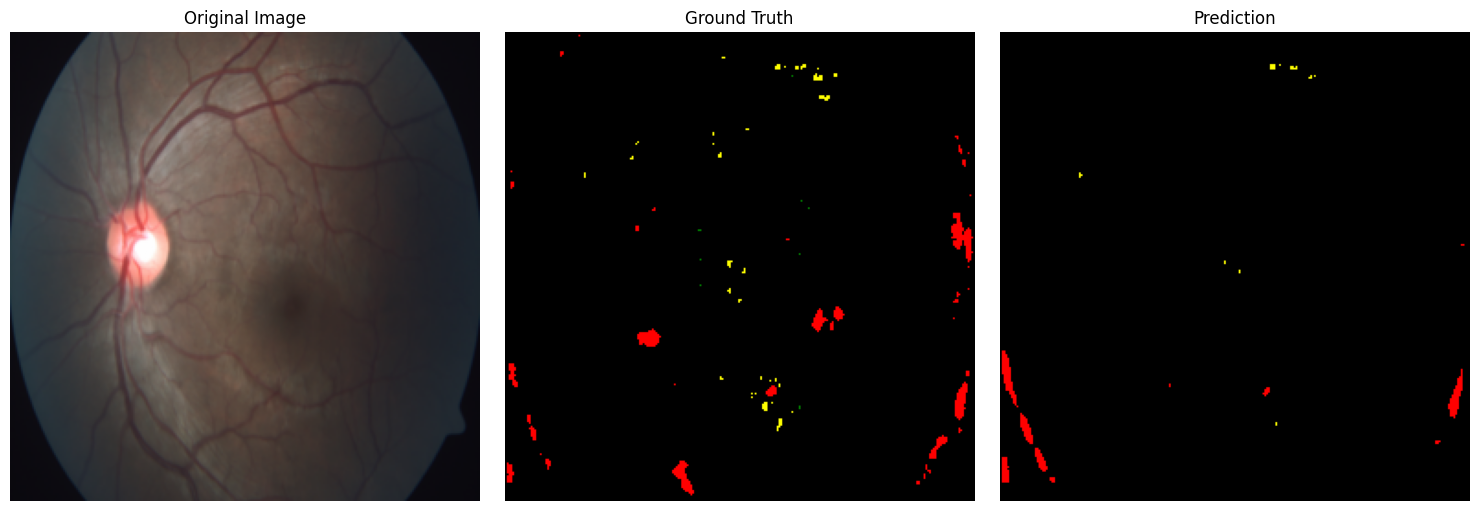

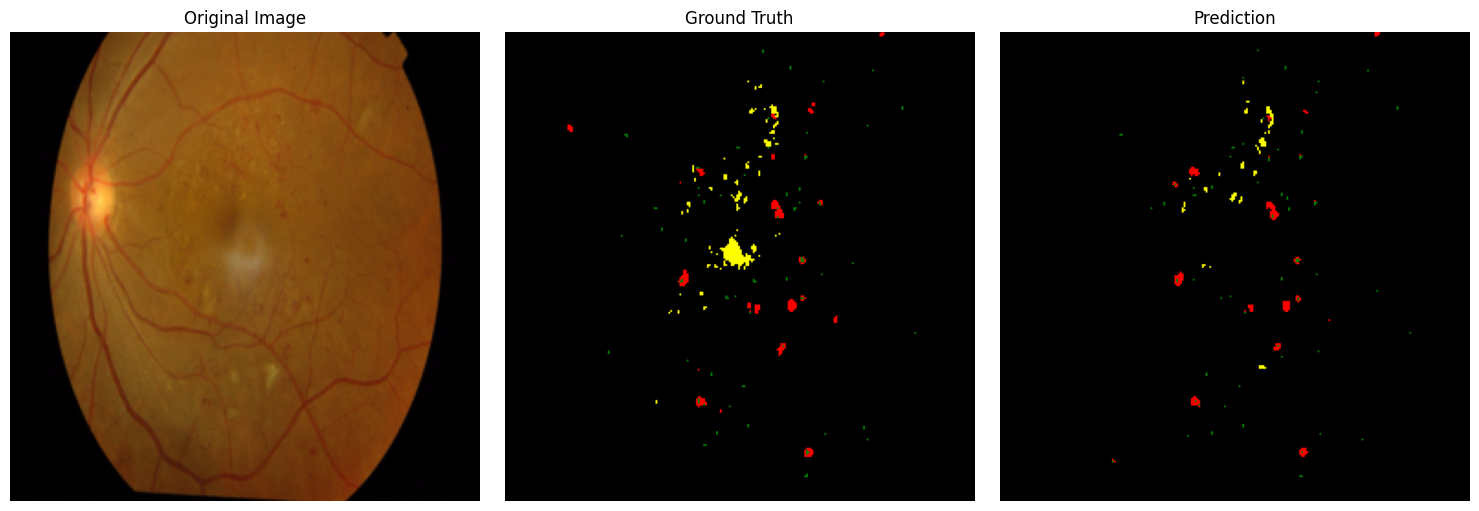

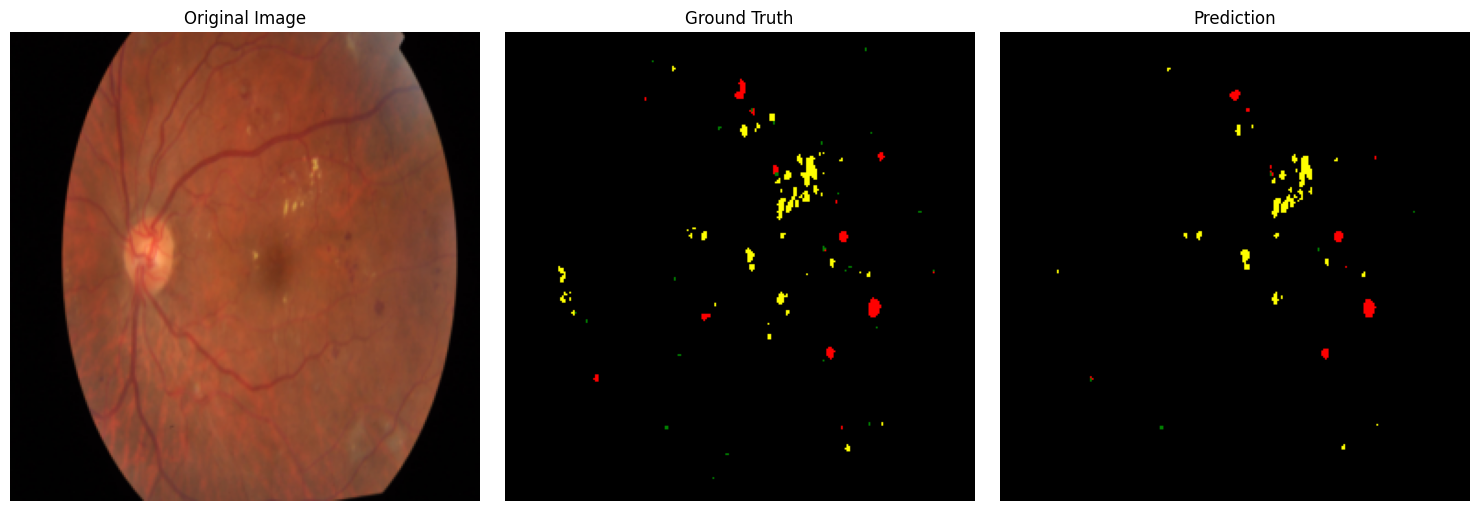

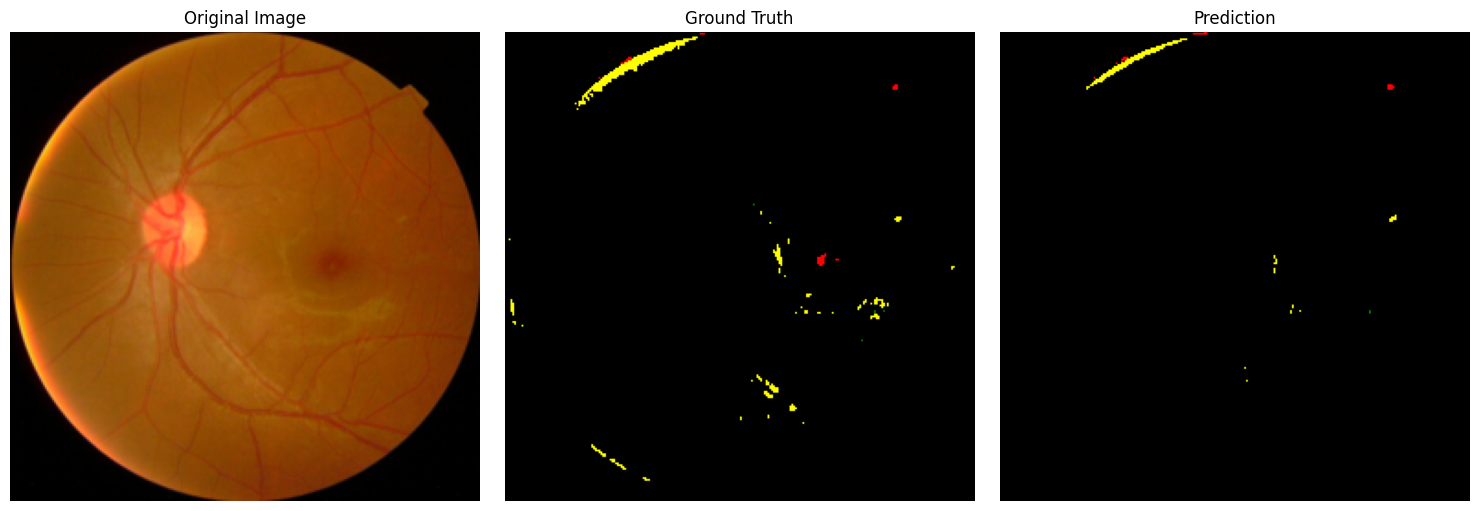

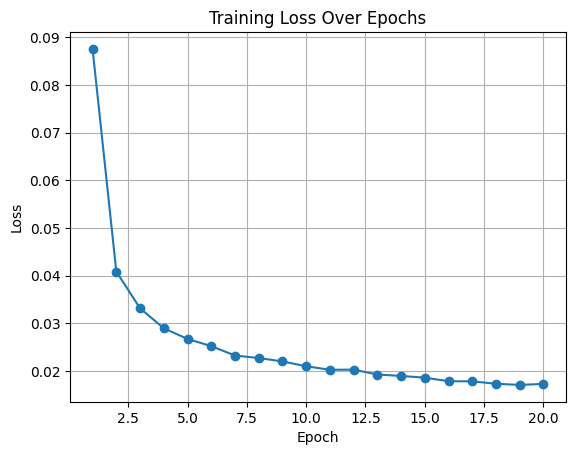

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import time

# Print CUDA information at the start
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=4):  # 4 classes: background, haemorrhages, hard exudates, microaneurysm
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(512, 1024)
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.up_conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.up_conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.up_conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.up_conv4(x)
        
        logits = self.outc(x)
        return logits

class RetinalMultiClassDataset(Dataset):
    def __init__(self, 
                 image_dir, 
                 haemorrhages_mask_dir, 
                 hard_exudates_mask_dir, 
                 microaneurysm_mask_dir,
                 transform=None):
        self.image_dir = Path(image_dir)
        self.haemorrhages_mask_dir = Path(haemorrhages_mask_dir)
        self.hard_exudates_mask_dir = Path(hard_exudates_mask_dir)
        self.microaneurysm_mask_dir = Path(microaneurysm_mask_dir)
        self.transform = transform
        
        # Verify directories exist
        for dir_path in [self.image_dir, self.haemorrhages_mask_dir, self.hard_exudates_mask_dir, self.microaneurysm_mask_dir]:
            if not dir_path.exists():
                print(f"WARNING: Directory does not exist: {dir_path}")
                print(f"Current working directory: {os.getcwd()}")
                print(f"Available directories: {os.listdir('.')}")
        
        # Get list of image files
        try:
            self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            print(f"Found {len(self.images)} images in {image_dir}")
            if len(self.images) == 0:
                print(f"WARNING: No images found in {image_dir}")
        except FileNotFoundError:
            print(f"ERROR: Directory not found: {image_dir}")
            self.images = []
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            img_name = self.images[idx]
            img_path = str(self.image_dir / img_name)
            
            # Check if image exists
            if not os.path.exists(img_path):
                print(f"WARNING: Image not found: {img_path}")
                # Return a dummy tensor if image not found
                return torch.zeros((3, 256, 256)), torch.zeros((256, 256), dtype=torch.long)
            
            image = Image.open(img_path).convert('RGB')
            
            # Load individual masks
            # Assuming mask filenames match image filenames
            haemorrhage_mask_path = str(self.haemorrhages_mask_dir / img_name)
            hard_exudate_mask_path = str(self.hard_exudates_mask_dir / img_name)
            microaneurysm_mask_path = str(self.microaneurysm_mask_dir / img_name)
            
            # Check if mask files exist
            if not os.path.exists(haemorrhage_mask_path):
                print(f"WARNING: Haemorrhage mask not found: {haemorrhage_mask_path}")
                haemorrhage_mask = Image.new('L', image.size, 0)
            else:
                haemorrhage_mask = Image.open(haemorrhage_mask_path).convert('L')
            
            if not os.path.exists(hard_exudate_mask_path):
                print(f"WARNING: Hard exudate mask not found: {hard_exudate_mask_path}")
                hard_exudate_mask = Image.new('L', image.size, 0)
            else:
                hard_exudate_mask = Image.open(hard_exudate_mask_path).convert('L')
            
            if not os.path.exists(microaneurysm_mask_path):
                print(f"WARNING: Microaneurysm mask not found: {microaneurysm_mask_path}")
                microaneurysm_mask = Image.new('L', image.size, 0)
            else:
                microaneurysm_mask = Image.open(microaneurysm_mask_path).convert('L')
            
            # Apply transforms to image and masks
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
            
            image = transform(image)
            
            # Transform masks and convert to binary (0 or 1)
            haemorrhage_mask = transform(haemorrhage_mask) > 0.5
            hard_exudate_mask = transform(hard_exudate_mask) > 0.5
            microaneurysm_mask = transform(microaneurysm_mask) > 0.5
            
            # Create a multi-class mask where:
            # 0: Background
            # 1: Haemorrhages
            # 2: Hard Exudates
            # 3: Microaneurysms
            multi_class_mask = torch.zeros((1, 256, 256), dtype=torch.long)
            
            # Set the values for each class
            # Priority: if pixels belong to multiple classes, choose one based on priority
            multi_class_mask[haemorrhage_mask] = 1
            multi_class_mask[hard_exudate_mask] = 2
            multi_class_mask[microaneurysm_mask] = 3
            
            return image, multi_class_mask.squeeze(0)
        
        except Exception as e:
            print(f"ERROR in __getitem__ for index {idx}, image {self.images[idx] if idx < len(self.images) else 'invalid index'}: {str(e)}")
            # Return a dummy tensor if error occurs
            return torch.zeros((3, 256, 256)), torch.zeros((256, 256), dtype=torch.long)

class RetinalSegmentation:
    def __init__(self, n_classes=4):
        # Set device with explicit error handling
        if torch.cuda.is_available():
            try:
                self.device = torch.device('cuda')
                # Test CUDA by creating a small tensor
                test_tensor = torch.zeros(1, device=self.device)
                del test_tensor  # Clean up
                print("Successfully initialized CUDA device")
            except RuntimeError as e:
                print(f"CUDA error: {e}")
                print("Falling back to CPU")
                self.device = torch.device('cpu')
        elif torch.backends.mps.is_available():
            try:
                self.device = torch.device('mps')
                print("Using MPS (Metal Performance Shaders) device")
            except:
                print("MPS initialization failed, falling back to CPU")
                self.device = torch.device('cpu')
        else:
            self.device = torch.device('cpu')
            print("Using CPU device")
        
        # Initialize model
        try:
            self.model = UNet(n_channels=3, n_classes=n_classes).to(self.device)
            print(f"Model initialized and moved to {self.device}")
        except Exception as e:
            print(f"Error initializing model: {e}")
            sys.exit(1)
            
        self.n_classes = n_classes
        
    def train(self, train_loader, num_epochs=10):
        # Check if dataloader has any samples
        if len(train_loader) == 0:
            print("ERROR: DataLoader is empty. Cannot train on empty dataset.")
            return
            
        # Use Cross Entropy Loss for multi-class segmentation
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        
        print(f"Training on {self.device}")
        print(f"Training with {len(train_loader)} batches per epoch")
        
        # List to store average loss for each epoch
        epoch_losses = []
        
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            start_time = time.time()
            
            print(f"Starting epoch {epoch+1}/{num_epochs}")
            
            for batch_idx, (images, masks) in enumerate(train_loader):
                # Print progress every 5 batches
                if batch_idx % 5 == 0:
                    print(f"  Processing batch {batch_idx+1}/{len(train_loader)}")
                
                try:
                    # Move data to device
                    images = images.to(self.device)
                    masks = masks.to(self.device)
                    
                    # Check for NaN values
                    if torch.isnan(images).any() or torch.isnan(masks).any():
                        print(f"WARNING: NaN values detected in input data (batch {batch_idx+1})")
                        continue
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = self.model(images)  # [B, C, H, W]
                    
                    # Print shape information for debugging
                    if batch_idx == 0 and epoch == 0:
                        print(f"Input shape: {images.shape}")
                        print(f"Output shape: {outputs.shape}")
                        print(f"Target shape: {masks.shape}")
                    
                    # Compute loss
                    loss = criterion(outputs, masks)
                    
                    # Check if loss is NaN
                    if torch.isnan(loss):
                        print(f"WARNING: NaN loss detected in batch {batch_idx+1}")
                        continue
                    
                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    
                    # Force CUDA synchronization to detect actual GPU usage
                    if self.device.type == 'cuda':
                        torch.cuda.synchronize()
                        
                except Exception as e:
                    print(f"ERROR in training loop (batch {batch_idx+1}): {str(e)}")
                    continue
            
            # Calculate average loss for this epoch
            avg_loss = running_loss / len(train_loader)
            epoch_losses.append(avg_loss)
            
            epoch_time = time.time() - start_time
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s')
            
            # Validate after every few epochs
            if epoch % 2 == 0:
                try:
                    self.evaluate_sample(train_loader)
                except Exception as e:
                    print(f"Error in evaluation: {e}")
        
        # Plot the training loss over epochs
        try:
            plt.figure()
            plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss Over Epochs')
            plt.grid(True)
            plt.savefig('training_loss.png')  # Save to file instead of showing
            print("Training loss plot saved to 'training_loss.png'")
        except Exception as e:
            print(f"Error plotting training loss: {e}")
    
    def predict(self, image):
        """Generate prediction for a single image"""
        self.model.eval()
        with torch.no_grad():
            try:
                image = image.to(self.device)
                output = self.model(image.unsqueeze(0))
                probabilities = F.softmax(output, dim=1)
                predicted_mask = torch.argmax(probabilities, dim=1)
                return predicted_mask.squeeze().cpu().numpy()
            except Exception as e:
                print(f"Error in prediction: {e}")
                return np.zeros((256, 256), dtype=np.int64)
    
    def evaluate_sample(self, dataloader):
        """Visualize prediction on a sample from the dataset"""
        try:
            # Get a sample
            images, masks = next(iter(dataloader))
            image = images[0].to(self.device)
            mask = masks[0].cpu().numpy()
            
            # Generate prediction
            pred_mask = self.predict(image)
            
            # Visualize
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            
            # Original image
            axs[0].imshow(image.permute(1, 2, 0).cpu().numpy())
            axs[0].set_title('Original Image')
            axs[0].axis('off')
            
            # Ground truth mask
            colors = ['black', 'red', 'yellow', 'green']  # colors for different classes
            cmap = plt.matplotlib.colors.ListedColormap(colors)
            axs[1].imshow(mask, cmap=cmap, vmin=0, vmax=3)
            axs[1].set_title('Ground Truth')
            axs[1].axis('off')
            
            # Predicted mask
            axs[2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=3)
            axs[2].set_title('Prediction')
            axs[2].axis('off')
            
            plt.tight_layout()
            plt.savefig(f"sample_evaluation_{time.strftime('%Y%m%d_%H%M%S')}.png")
            print("Evaluation sample saved as image file")
        except Exception as e:
            print(f"Error in evaluation: {e}")

# Example usage
def main():
    print("\n" + "="*50)
    print("Starting retinal segmentation training script")
    print("="*50 + "\n")
    
    # Directory paths - modify these to match your actual directory structure
    image_dir = 'train_images'
    haemorrhages_mask_dir = 'APTOS 2019 Blindness Detection Segmented/Haemorrhages/train_images'
    hard_exudates_mask_dir = 'APTOS 2019 Blindness Detection Segmented/Hard Exudates/train_images'
    microaneurysm_mask_dir = 'APTOS 2019 Blindness Detection Segmented/Microaneurysm/train_images'
    
    # Check if directories exist
    for dir_path in [image_dir, haemorrhages_mask_dir, hard_exudates_mask_dir, microaneurysm_mask_dir]:
        if not os.path.exists(dir_path):
            print(f"WARNING: Directory does not exist: {dir_path}")
    
    print("Creating dataset...")
    dataset = RetinalMultiClassDataset(
        image_dir=image_dir,
        haemorrhages_mask_dir=haemorrhages_mask_dir,
        hard_exudates_mask_dir=hard_exudates_mask_dir,
        microaneurysm_mask_dir=microaneurysm_mask_dir
    )
    
    if len(dataset) == 0:
        print("ERROR: Dataset is empty. Please check your directory paths and image files.")
        return
    
    print(f"Dataset created with {len(dataset)} samples")
    
    # Verify a few samples can be loaded
    print("Verifying dataset by loading first sample...")
    try:
        sample_img, sample_mask = dataset[0]
        print(f"Sample image shape: {sample_img.shape}")
        print(f"Sample mask shape: {sample_mask.shape}")
    except Exception as e:
        print(f"ERROR: Failed to load sample from dataset: {e}")
    
    print("Creating data loader...")
    train_loader = DataLoader(
        dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,  # Set to 0 for debugging
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print("Initializing segmentation model...")
    segmentation = RetinalSegmentation(n_classes=4)
    
    print("Starting training...")
    segmentation.train(train_loader, num_epochs=20)
    
    # Save the trained model
    try:
        torch.save(segmentation.model.state_dict(), 'retinal_segmentation_model.pth')
        print("Model saved successfully to 'retinal_segmentation_model.pth'")
    except Exception as e:
        print(f"ERROR: Failed to save model: {e}")
    
    print("\n" + "="*50)
    print("Training completed")
    print("="*50 + "\n")
    
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Unhandled exception in main: {e}")
        import traceback
        traceback.print_exc()